# Importing all the libraries

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix

# Defining the paths

In [2]:
train_dir = 'Skin_Types/train'
valid_dir = 'Skin_Types/valid'
test_dir = 'Skin_Types/test'

# Load the images and augment training data using ImageDataGenerator

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
valid_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

# Pre-processing 

In [5]:
train_dataset = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical'
)
valid_dataset = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical'
)
test_dataset = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical'
)

Found 1165 images belonging to 4 classes.
Found 234 images belonging to 4 classes.
Found 225 images belonging to 4 classes.


# Freezing the pre-trained model layers from MobileNetV2

In [29]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False

# Adding dense layers and defining the output layer

In [30]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(4, activation='softmax')
])

# Summary of the model

In [31]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │          40,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │              68 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,299,572 (8.77 MB)

 Trainable params: 41,588 (162.45 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

# Compiling the model

In [32]:
model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Reduce learning rate when val_accuracy fluctuates

In [33]:
lr_scheduler = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=1, verbose=1)

# Training the model

In [ ]:
history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=valid_dataset,
    callbacks=[lr_scheduler]
)

# Plotting model accuracy and model loss graph

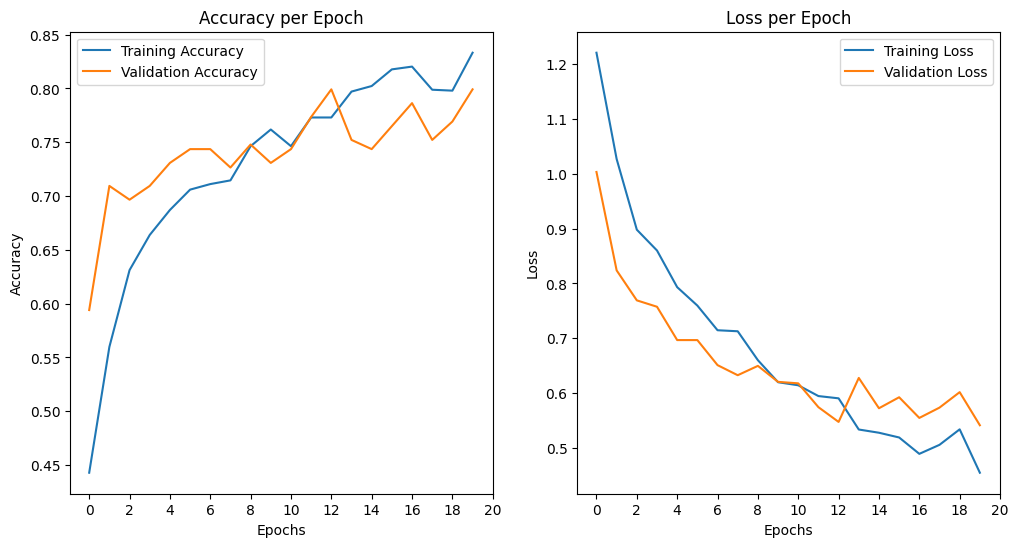

In [62]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

epochs = range(1, len(history.history['accuracy']) + 1)
plt.xticks(np.arange(0, len(epochs) + 1, step=2))

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.xticks(np.arange(0, len(epochs) + 1, step=2))

plt.show()

# Evaluating the model

In [99]:
train_loss, train_accuracy = model.evaluate(train_dataset)
print(f"Training Loss: {train_loss}")
print(f"Training Accuracy: {train_accuracy}")

C:\Users\Hizkia\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


73/73 ━━━━━━━━━━━━━━━━━━━━ 67s 922ms/step - accuracy: 0.9091 - loss: 0.2945
Training Loss: 0.2922196686267853
Training Accuracy: 0.9071367383003235


In [100]:
val_loss, val_accuracy = model.evaluate(valid_dataset)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 705ms/step - accuracy: 0.7861 - loss: 0.5272
Validation Loss: 0.5413596630096436
Validation Accuracy: 0.7991452813148499


In [101]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 325ms/step - accuracy: 0.8351 - loss: 0.4362
Test Loss: 0.43529653549194336
Test Accuracy: 0.8322147727012634


# Saving the model

In [4]:
model.save('FaceDetectionModel.keras')

In [3]:
model = load_model('FaceDetectionModel.keras')

# Testing the model using faces outside of dataset

FileUpload(value=(), accept='image/*', description='Upload')

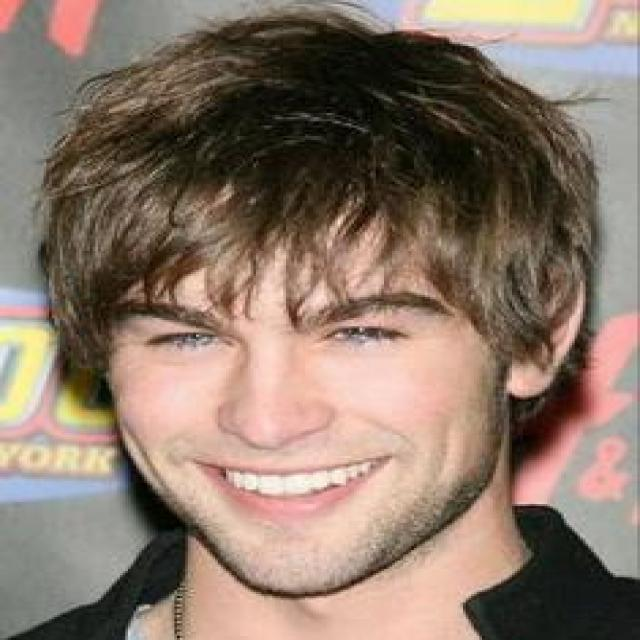

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Predicted Class: Normal | Probability: 100.00%

Probabilities for each class:
- Dry: 0.00%
- Normal: 100.00%
- Oily: 0.00%
- Sensitive: 0.00%


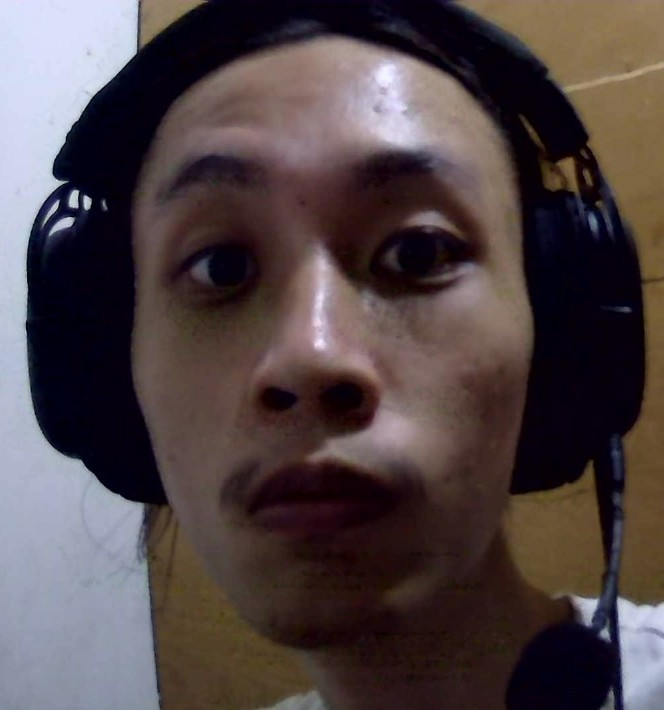

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Predicted Class: Oily | Probability: 68.65%

Probabilities for each class:
- Dry: 19.58%
- Normal: 8.82%
- Oily: 68.65%
- Sensitive: 2.95%


In [ ]:
import numpy as np
import ipywidgets as widgets
from IPython.display import display
from PIL import Image
from io import BytesIO
import tensorflow as tf

class_names = ['dry', 'normal', 'oily', 'sensitive']

file_upload = widgets.FileUpload(
    accept='image/*', 
    multiple=False 
)

def predict_image(image):
    image = image.resize((224, 224))
    image_array = np.array(image)
    
    image_array = image_array / 255.0
    
    image_array = np.expand_dims(image_array, axis=0)
    
    predictions = model.predict(image_array)
    
    probabilities = predictions[0]
    
    class_probabilities = {class_names[i]: prob * 100 for i, prob in enumerate(probabilities)}
    
    predicted_class = np.argmax(probabilities)
    predicted_probability = np.max(probabilities) * 100
    
    return class_probabilities, class_names[predicted_class], predicted_probability

def on_upload_change(change):
    if file_upload.value:
        try:
            uploaded_file = file_upload.value[0]
            image_data = uploaded_file['content']
            
            image = Image.open(BytesIO(image_data))
            
            display(image)
            
            class_probabilities, predicted_class, probability = predict_image(image)
            
            print(f"Predicted Class: {predicted_class.capitalize()} | Probability: {probability:.2f}%")
            
            print("\nProbabilities for each class:")
            for class_name, prob in class_probabilities.items():
                print(f"- {class_name.capitalize()}: {prob:.2f}%")
                
        except Exception as e:
            print(f"Error: {e}")

file_upload.observe(on_upload_change, names='value')

display(file_upload)

# Plotting confusion matrix

C:\Users\Hizkia\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 819ms/step


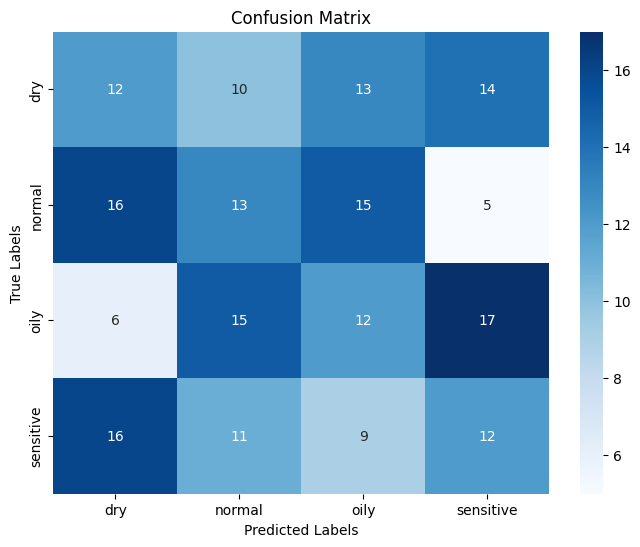

In [20]:
test_predictions = model.predict(test_dataset, verbose=1)
true_labels = test_dataset.classes
predicted_labels = np.argmax(test_predictions, axis=1)
cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_dataset.class_indices.keys(), yticklabels=test_dataset.class_indices.keys())
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()